## Link Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive/Colab Notebooks/Capstone"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install xlrd

import tensorflow
tensorflow.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Select Data

Don't run it again once we have the cleaned file.

In [0]:
def select_cols(cols=['Unnamed: 0','form','findexdate','only_eng_words','sec_full_path'],
                input_name = ['21centfoxinc','attinc','cbscorp','comcastcorp','verizoncom'],
                output_name = ['fox','att','cbs','comcast','verizon']):
  for i in range(len(input_name)):
    df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files/cleaned_data_updated_%s_sec_files.csv' % input_name[i],sep='|',
                     usecols=cols)
    if input_name[i]=='cbscorp':
      df = df[df['sec_full_path']!='https://www.sec.gov/Archives/edgar/data/813828/0000950136-06-004285.txt']
      df.reset_index(drop=True, inplace=True)
      df = df.drop(columns=['sec_full_path'])
    elif input_name[i]=='verizoncom':
      df = df[df['sec_full_path']!='https://www.sec.gov/Archives/edgar/data/732712/0000909518-11-000031.txt']
      df.reset_index(drop=True, inplace=True)
      df = df.drop(columns=['sec_full_path'])
    df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/%s.csv' % output_name[i],index=False)
    
select_cols()

## Clean Dictionary

Don't run it again once we have the cleaned file.

In [0]:
lm_dic = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/LoughranMcDonald_MasterDictionary_2016.csv')
lm_words = lm_dic[['Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting','Modal']].astype(bool)
lm_dic_clean = lm_dic[lm_words.Negative | lm_words.Positive | lm_words.Uncertainty | lm_words.Litigious | lm_words.Constraining | lm_words.Superfluous | lm_words.Interesting | lm_words.Modal]
lm_dic_clean = lm_dic_clean[['Word','Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting','Modal']]
lm_dic_clean = lm_dic_clean.reset_index(drop=True)
lm_1 = lm_dic_clean[['Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting']]
lm_2 = lm_dic_clean[['Word','Modal']]
lm_1[lm_1>0]=1
lm_export = pd.merge(lm_2, lm_1, left_index=True, right_index=True)
lm_export.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/lm_dic_clean.csv',index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


## Load Dictionary

Don't run it again once we have the cleaned file.

In [0]:
lm = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/lm_dic_clean.csv')

## Load Event
Don't run it again once we have the cleaned file.

In [0]:
def remove_newlines(df):
  stripped = []
  for i in range(df.shape[0]):
    item = df['Item_text'][i][2:-2].replace('\\n','')
    stripped.append(item)
    #if item=='':
      #stripped.append('none')
    #else:
      #stripped.append(item)
  return stripped

def load_event(mycompany=['verizon','cbs','att','fox','comcast']):
  if mycompany[0]=='verizon':
    event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % mycompany[0],sep='|')
    event['findexdate'] = pd.to_datetime(event['findexdate'])
    event = event[event['findexdate']<"2000-01-01"].append(event[event['findexdate']>="2006-02-03"],ignore_index=True)
    event = event[['Item_text','Item_category']]
  else:
    event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % mycompany[0],sep='|',usecols=['Item_text','Item_category'])
  for i in range(1,len(mycompany)):
    if mycompany[i]=='fox':
      cur_event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % '21cent',sep='|',usecols=['Item_text','Item_category'])
    elif mycompany[i]=='verizon':
      cur_event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % 'verizon',sep='|')
      cur_event['findexdate'] = pd.to_datetime(cur_event['findexdate'])
      cur_event = cur_event[cur_event['findexdate']<"2000-01-01"].append(cur_event[cur_event['findexdate']>="2006-02-03"],ignore_index=True)
      cur_event = cur_event[['Item_text','Item_category']]
    else:
      cur_event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % mycompany[i],sep='|',usecols=['Item_text','Item_category'])
      
    event = event.append(cur_event,ignore_index=True)
    
    # remove new lines from event
  event['stripped_event'] = remove_newlines(event)
  event.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/event.csv',index=False)

load_event()

## Load  SEC Filings and Map Sentiment

Don't run it again once we have the cleaned file.

In [0]:
# sentiment frequency

def map_sentiment(df):
  df_list = []
  result = []
  length = []
  for i in range(len(df)):
    print(i)
    cur_df = pd.DataFrame({'Word':df['only_eng_words'][i].split()})
    length.append(len(cur_df['Word']))
    # map each word with sentiment
    merged_df = pd.merge(cur_df,lm,how='inner')
    df_list.append(merged_df)
    result.append(list(merged_df.apply(np.sum,axis = 0))[1:])
  result = [*zip(*result)]   # take transpose
  result_df = pd.merge(df,pd.DataFrame({
                                        'Sentiment':df_list,
                                        'Modal':result[0],
                                        'Negative':result[1],
                                        'Positive':result[2],
                                        'Uncertainty':result[3],
                                        'Litigious':result[4],
                                        'Constraining':result[5],
                                        'Superfluous':result[6],
                                        'Interesting':result[7],
                                        'Doc_length':length
                                       }),left_index=True,right_index=True)
  result_df['Modal_freq'] = result_df['Modal']/result_df['Doc_length']
  result_df['Negative_freq'] = result_df['Negative']/result_df['Doc_length']
  result_df['Positive_freq'] = result_df['Positive']/result_df['Doc_length']
  result_df['Uncertainty_freq'] = result_df['Uncertainty']/result_df['Doc_length']
  result_df['Litigious_freq'] = result_df['Litigious']/result_df['Doc_length']
  result_df['Constraining_freq'] = result_df['Constraining']/result_df['Doc_length']
  result_df['Superfluous_freq'] = result_df['Superfluous']/result_df['Doc_length']
  result_df['Interesting_freq'] = result_df['Interesting']/result_df['Doc_length']
  result_df['Negative_score'] = (result_df['Negative']-result_df['Positive'])/result_df['Doc_length']
  return(result_df[['Unnamed: 0','form','findexdate','Sentiment','Modal_freq','Negative_freq','Positive_freq',
                   'Uncertainty_freq','Litigious_freq','Constraining_freq','Superfluous_freq','Interesting_freq',
                   'Negative_score']])

def map_sentiment_all(name = ['fox','att','cbs','comcast','verizon']):
  for company in name:
    sec = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/%s.csv' % company)
    sec['only_eng_words'] = sec['only_eng_words'].str.upper()
    sec_sentiment = map_sentiment(sec)
    sec_sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/%s_sentiment.csv' % company,index=False)
    
map_sentiment_all()

In [0]:
# sentiment present

def map_sentiment(df):
  df_list = []
  result = []
  length = []
  for i in range(len(df)):
    cur_df = pd.DataFrame({'Word':df['only_eng_words'][i].split()})
    length.append(len(cur_df['Word']))
    # map each word with sentiment
    merged_df = pd.merge(cur_df,lm,how='inner')
    df_list.append(merged_df)
    result.append(list(merged_df.apply(np.sum,axis = 0))[1:])
  result = [*zip(*result)]   # take transpose
  result_df = pd.merge(df,pd.DataFrame({
                                        'Sentiment':df_list,
                                        'Modal':result[0],
                                        'Negative':result[1],
                                        'Positive':result[2],
                                        'Uncertainty':result[3],
                                        'Litigious':result[4],
                                        'Constraining':result[5],
                                        'Superfluous':result[6],
                                        'Interesting':result[7],
                                        'Doc_length':length
                                       }),left_index=True,right_index=True)

  return(result_df[['Unnamed: 0','form','findexdate','Sentiment','Modal','Negative','Positive',
                   'Uncertainty','Litigious','Constraining','Superfluous','Interesting']])

def map_sentiment_all(name = ['fox','att','cbs','comcast','verizon']):
  for company in name:
    sec = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/%s.csv' % company)
    sec['only_eng_words'] = sec['only_eng_words'].str.upper()
    sec_sentiment = map_sentiment(sec)
    sec_sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/%s_sentiment_count.csv' % company,index=False)
    
map_sentiment_all()

## Load Event and Map Sentiment

In [0]:
def map_event_sentiment(df):
  df_list = []
  result = []
  length = []
  for i in range(len(df)):
    cur_df = pd.DataFrame({'Word':df['stripped_event'][i].split()})
    cur_df['Word'] = cur_df['Word'].str.upper()
    length.append(len(cur_df['Word']))
    # map each word with sentiment
    merged_df = pd.merge(cur_df,lm,how='inner')
    df_list.append(merged_df)
    result.append(list(merged_df.apply(np.sum,axis = 0))[1:])
  result = [*zip(*result)]   # take transpose
  result_df = pd.merge(df,pd.DataFrame({
                                        'Sentiment':df_list,
                                        'Modal':result[0],
                                        'Negative':result[1],
                                        'Positive':result[2],
                                        'Uncertainty':result[3],
                                        'Litigious':result[4],
                                        'Constraining':result[5],
                                        'Superfluous':result[6],
                                        'Interesting':result[7],
                                        'Doc_length':length
                                       }),left_index=True,right_index=True)
  
  result_df['Modal_freq'] = result_df['Modal']/result_df['Doc_length']
  result_df['Negative_freq'] = result_df['Negative']/result_df['Doc_length']
  result_df['Positive_freq'] = result_df['Positive']/result_df['Doc_length']
  result_df['Uncertainty_freq'] = result_df['Uncertainty']/result_df['Doc_length']
  result_df['Litigious_freq'] = result_df['Litigious']/result_df['Doc_length']
  result_df['Constraining_freq'] = result_df['Constraining']/result_df['Doc_length']
  result_df['Superfluous_freq'] = result_df['Superfluous']/result_df['Doc_length']
  result_df['Interesting_freq'] = result_df['Interesting']/result_df['Doc_length']
  result_df['Negative_score'] = (result_df['Negative']-result_df['Positive'])/result_df['Doc_length']
  
  fdate = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all.csv',usecols=['findexdate'])
  df_merged = pd.concat([fdate,result_df], axis=1)
  return(df_merged)

event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/event.csv')
event['stripped_event'] = event['stripped_event'].fillna('NONE')
event_sentiment = map_event_sentiment(event)
event_sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/event_sentiment.csv',index=False)

## Stack Sentiment Features

Don't run it again once we have the cleaned file.

In [0]:
# frequency
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment.csv')
comcast = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment.csv')
att = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment.csv')
verizon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment.csv')
verizon = verizon[verizon['findexdate']<"2000-01-01"].append(verizon[verizon['findexdate']>="2006-02-03"],ignore_index=True)
cbs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment.csv')
sentiment_features = pd.concat([fox,comcast,att,verizon,cbs],ignore_index=True)
sentiment_features = sentiment_features.sort_values('Unnamed: 0')
sentiment_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all.csv',index=False)

In [0]:
# count
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment_count.csv')
comcast = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment_count.csv')
att = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment_count.csv')
verizon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment_count.csv')
verizon = verizon[verizon['findexdate']<"2000-01-01"].append(verizon[verizon['findexdate']>="2006-02-03"],ignore_index=True)
cbs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment_count.csv')
sentiment_features = pd.concat([fox,comcast,att,verizon,cbs],ignore_index=True)
sentiment_features = sentiment_features.sort_values('Unnamed: 0')
sentiment_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all_count.csv',index=False)

## Stack Content of Files

In [0]:
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selcted/fox.csv',usecols=['only_eng_words'])
comcast = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment.csv')
att = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment.csv')
verizon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment.csv')
verizon = verizon[verizon['findexdate']<"2000-01-01"].append(verizon[verizon['findexdate']>="2006-02-03"],ignore_index=True)
cbs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment.csv')
sentiment_features = pd.concat([fox,comcast,att,verizon,cbs],ignore_index=True)
sentiment_features = sentiment_features.sort_values('Unnamed: 0')
sentiment_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all.csv',index=False)

## Load Individual Moody's Rating, Sentiment

In [0]:
def load_data(company):
  '''
  The output of this function are used as inputs of interactive plots.
  '''
  moodys = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Capstone/Columbia DSIC 2018 - Moody\'s data.xlsx',sheet_name='Sheet1')
  if company == 'fox':
    mycompany = '21st Century Fox America'
    moodys = moodys.loc[moodys['Company']=='21st Century Fox America']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment.csv')    
  elif company == 'verizon':
    mycompany = 'Verizon Communications Inc'
    moodys = moodys.loc[moodys['Company']=='Verizon Communications Inc']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment.csv')
    sentiment = sentiment[sentiment['findexdate']<"2000-01-01"].append(sentiment[sentiment['findexdate']>="2006-02-03"],ignore_index=True)
  elif company == 'comcast':
    mycompany = 'Comcast Corp'
    moodys = moodys.loc[moodys['Company']=='Comcast Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment.csv')
  elif company == 'att':
    mycompany = 'AT&T Corp'
    moodys = moodys.loc[moodys['Company']=='AT&T Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment.csv')
  elif company == 'cbs':
    mycompany = 'CBS Corp'
    moodys = moodys.loc[moodys['Company']=='CBS Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment.csv')  
  return((moodys,sentiment,mycompany))

# moodys, sentiment, company = load_data('verizon')



def load_sentiment_stacked(mycompany=['verizon','cbs','att','fox','comcast']):
  moodys,sentiment,company=load_data(mycompany[0])
  for i in range(1,len(mycompany)):
    cur_moodys,cur_sentiment,cur_company=load_data(mycompany[i])
    sentiment = sentiment.append(cur_sentiment,ignore_index=True)
  sentiment['findexdate'] = pd.to_datetime(sentiment['findexdate'])
  sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment.csv',index=False)
  return sentiment

load_sentiment_stacked()

# Run Below

run one of the three below

In [0]:
# sentiment frequency score of entire file
def data_merge():
  sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all.csv')
  sentiment['findexdate'] = pd.to_datetime(sentiment['findexdate'])
  event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/event.csv')
  event['stripped_event'] = event['stripped_event'].fillna('NONE')
  return pd.concat([sentiment, event], axis=1)

features = data_merge()

In [0]:
# sentiment count score of entire file
def data_merge():
  sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all_count.csv')
  sentiment['findexdate'] = pd.to_datetime(sentiment['findexdate'])
  event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/event.csv')
  event['stripped_event'] = event['stripped_event'].fillna('NONE')
  return pd.concat([sentiment, event], axis=1)

features = data_merge()

In [0]:
# sentiment score of event
features = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/event_sentiment.csv')

In [0]:
item = features['Item_category'].tolist()
my_categories = []
for x in item:
  print(type(x))
  my_categories.append(x)
  print(my_categories)
  break
my_categories

<class 'str'>
["['5.  Other Events.']"]


["['5.  Other Events.']"]

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
cat_features = ['color', 'director_name', 'actor_2_name']
enc = LabelEncoder()
enc.fit(cat_features)
new_cat_features = enc.transform(cat_features)
print new_cat_features # [1 2 0]
new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
print ohe.fit_transform(new_cat_features)

encoder = OneHotEncoder()
encoder.fit(features['Item_category'][:10])

## Prepare Training Data

In [4]:
def prepare_train(num_words=1000,max_len=50,df = features):
  df['findexdate'] = pd.to_datetime(df['findexdate'])
  df = df.fillna(0)
  df_train = df[df['findexdate']<pd.to_datetime('2018-07-01')]
  df_test = df[df['findexdate']>=pd.to_datetime('2018-07-01')]
  x_train_bow = list(df_train['stripped_event'])
  x_test_bow = list(df_test['stripped_event'])
  for i in range(len(x_train_bow)):
    x_train_bow[i] = x_train_bow[i].translate(str.maketrans('','','1234567890_'))
  for i in range(len(x_test_bow)):
    x_test_bow[i] = x_test_bow[i].translate(str.maketrans('','','1234567890_'))
  
  t = Tokenizer(num_words=num_words)
  t.fit_on_texts(df_train['stripped_event'])
  x_train_text = t.texts_to_sequences(df_train['stripped_event'])
  x_train_text = pad_sequences(x_train_text, maxlen=max_len, padding='post')
  x_train_text = x_train_text.astype('float32')
  x_test_text = t.texts_to_sequences(df_test['stripped_event'])
  x_test_text = pad_sequences(x_test_text, maxlen=max_len, padding='post')
  x_test_text = x_test_text.astype('float32')
  
  
  # frequency  
  x_train_tabular = df_train[['Modal_freq','Negative_freq','Positive_freq',
                              'Uncertainty_freq','Litigious_freq','Constraining_freq',
                              'Superfluous_freq','Interesting_freq','Negative_score']]
  x_test_tabular = df_test[['Modal_freq','Negative_freq','Positive_freq',
                            'Uncertainty_freq','Litigious_freq','Constraining_freq',
                            'Superfluous_freq','Interesting_freq','Negative_score']]
  
  # count
  #x_train_tabular = df_train[['Modal','Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting']]
  #x_test_tabular = df_test[['Modal','Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting']]
  
  x_train_tabular = x_train_tabular.astype('float32')
  x_test_tabular = x_test_tabular.astype('float32')
  
  y_train = ['A1']*78+['A3']*183+['Baa1']*131+\
            ['Ba3']*16+['Ba2']*24+['Baa3']*11+['Baa1']*6+['A3']*79+['Baa3']*126+['Baa2']*115+\
            ['Aa3']*39+['A1']*25+['A2']*4+['A3']*4+['Baa2']*28+['Ba1']*41+['Baa2']*6+['A2']*196+['A3']*73+['Baa1']*124+['Baa2']*1+\
            ['Baa3']*74+['Baa2']*205+['Baa1']*758+\
            ['Ba1']*2+['Baa3']*32+['Baa2']*72+['Baa1']*59+['A3']*107 
  y_test = ['Baa1']*3+['Baa2']*7+['Baa2']*14+['Baa1']*11+['A3']*5
  
  # encode string labels into integer labels
  le = LabelEncoder()
  le.fit(y_train)
  print("Classes: ",le.classes_)
  
  y_train = le.transform(y_train)
  y_train = y_train.astype('int64')
  print("Train set distribution: \n",stats.itemfreq(y_train))
  y_train = np.reshape(y_train,(len(y_train),1))
  
  y_test = le.transform(y_test)
  y_test = y_test.astype('int64')
  print("Test set distribution: \n",stats.itemfreq(y_test))
  y_test = np.reshape(y_test,(len(y_test),1))
  
  return x_train_text,x_train_tabular,x_train_bow,y_train,x_test_text,x_test_tabular,x_test_bow,y_test

x_train_text,x_train_tabular,x_train_bow,y_train,x_test_text,x_test_tabular,x_test_bow,y_test = prepare_train()
print(x_train_tabular.shape,x_test_tabular.shape)

Classes:  ['A1' 'A2' 'A3' 'Aa3' 'Ba1' 'Ba2' 'Ba3' 'Baa1' 'Baa2' 'Baa3']
Train set distribution: 
 [[   0  103]
 [   1  200]
 [   2  446]
 [   3   39]
 [   4   43]
 [   5   24]
 [   6   16]
 [   7 1078]
 [   8  427]
 [   9  243]]
Test set distribution: 
 [[ 2  5]
 [ 7 14]
 [ 8 21]]
(2619, 9) (40, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


## Prepare Plot Helper Functions

In [0]:
def get_distribution(myfreq):
  dist = [0]*10
  for i in range(len(myfreq)):
    dist[myfreq[i][0]]=myfreq[i][1]
  return dist

def autolabel(rects,ax):
  """
  Attach a text label above each bar displaying its height
  """
  for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height),
            ha='center', va='bottom')

def plot_distribution(pred_label,actual_label,datatype='train'):
  N = 10

  ind = np.arange(N)  # the x locations for the groups
  width = 0.36        # the width of the bars
  
  fig, ax = plt.subplots()
  fig.set_figheight(9)
  fig.set_figwidth(16)

  rects1 = ax.bar(ind, pred_label, width, color='#B284BE')

  rects2 = ax.bar(ind + width, actual_label, width, color='#547d8b')

  # add some text for labels, title and axes ticks
  ax.set_ylabel('Count')
  ax.set_title('Predict Label vs Actual Label')
  ax.set_xticks(ind + width / 2)
  ax.set_xticklabels(['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3'])

  ax.legend((rects1[0], rects2[0]), ('Actual Label', 'Predicted Label'))

  autolabel(rects1,ax)
  autolabel(rects2,ax)
  
  plt.savefig('fig1_%s.pdf' % datatype, bbox_inches='tight')
  plt.savefig('fig1_%s.png' % datatype, bbox_inches='tight')
  plt.show()
  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds,
                          datatype='training'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for %s set" % datatype)
    else:
        print('Confusion matrix for %s set, without normalization' % datatype)

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Random Forest with Structured Data

{'randomforestclassifier__max_depth': array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])}
Random Forest with Polynomial Features: {'randomforestclassifier__max_depth': 10.0} 0.5192821687667049


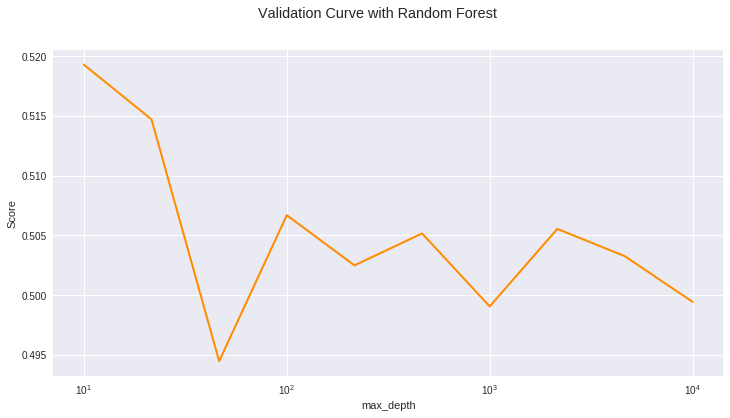

In [11]:
param_grid = {'randomforestclassifier__max_depth': np.logspace(1, 4, 10)}
print(param_grid)

rf_pipe = make_pipeline(RandomForestClassifier())
grid_rf = GridSearchCV(rf_pipe, param_grid, cv=10)
grid_rf.fit(x_train_tabular, np.reshape(y_train,(len(y_train),)))
print('Random Forest with Polynomial Features:', grid_rf.best_params_, grid_rf.best_score_ )

fig=plt.figure(figsize=(12, 6))
plt.suptitle("Validation Curve with Random Forest")
plt.xlabel("max_depth")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_grid['randomforestclassifier__max_depth'], grid_rf.cv_results_['mean_test_score'],
             label="Validation score",
             color="darkorange", lw=lw)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.


Pred label on train set:
 [[   0  109]
 [   1  192]
 [   2  436]
 [   3   46]
 [   4   81]
 [   5   36]
 [   6   18]
 [   7 1089]
 [   8  382]
 [   9  230]]
Pred accuracy on train set:  0.9473081328751431
Pred label on test set:
 [[ 1  6]
 [ 2  2]
 [ 7 25]
 [ 8  7]]
Pred accuracy on test set:  0.425
gdrive	rf_importance.pdf  rf_importance.png  sample_data
gdrive	sample_data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


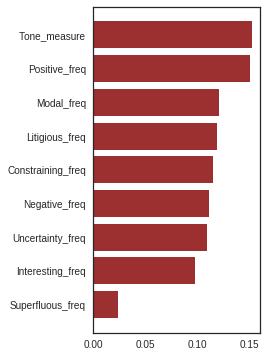

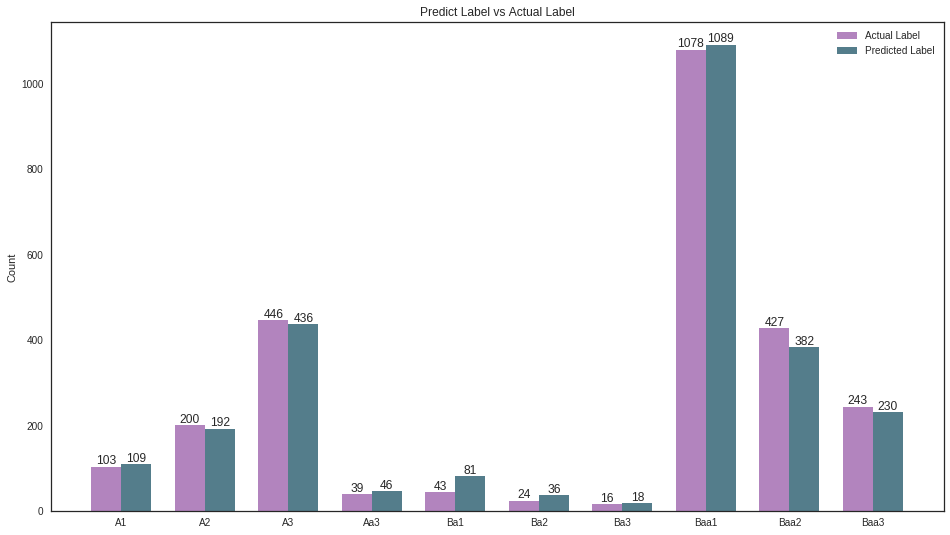

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


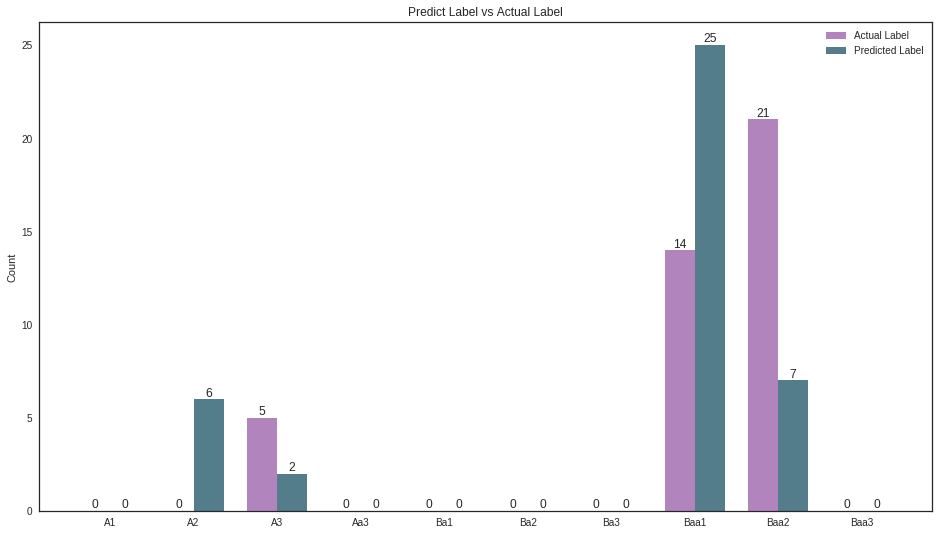

Confusion matrix for training set, without normalization
[[  97    0    0    5    0    0    0    1    0    0]
 [   2  182    0    0   14    0    0    2    0    0]
 [  10    1  425    0    2    1    0    6    1    0]
 [   0    0    0   39    0    0    0    0    0    0]
 [   0    1    0    0   42    0    0    0    0    0]
 [   0    0    4    0    0   20    0    0    0    0]
 [   0    0    1    0    0    2   13    0    0    0]
 [   0    0    3    0    0    5    5 1064    1    0]
 [   0    8    1    2   23    0    0    8  377    8]
 [   0    0    2    0    0    8    0    8    3  222]]
Normalized confusion matrix for training set
[[9.42e-01 0.00e+00 0.00e+00 4.85e-02 0.00e+00 0.00e+00 0.00e+00 9.71e-03
  0.00e+00 0.00e+00]
 [1.00e-02 9.10e-01 0.00e+00 0.00e+00 7.00e-02 0.00e+00 0.00e+00 1.00e-02
  0.00e+00 0.00e+00]
 [2.24e-02 2.24e-03 9.53e-01 0.00e+00 4.48e-03 2.24e-03 0.00e+00 1.35e-02
  2.24e-03 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix for test set
[[ nan  nan  nan  nan]
 [0.   0.   1.   0.  ]
 [0.14 0.   0.79 0.07]
 [0.19 0.1  0.43 0.29]]
fig1_test.pdf	gdrive			       rf_confusion_matrix_train.png
fig1_test.png	rf_confusion_matrix_test.pdf   sample_data
fig1_train.pdf	rf_confusion_matrix_test.png
fig1_train.png	rf_confusion_matrix_train.pdf
fig1_test.pdf  fig1_train.pdf  gdrive
fig1_test.png  fig1_train.png  sample_data


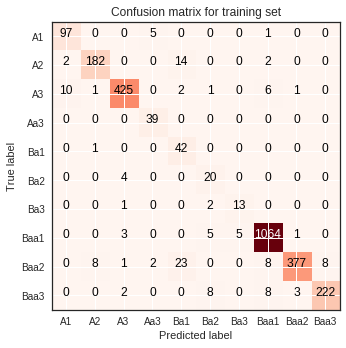

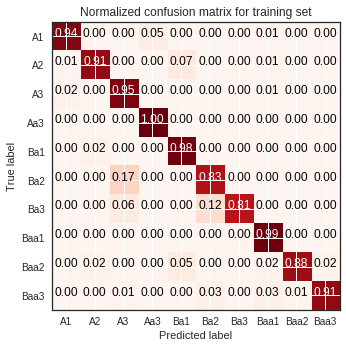

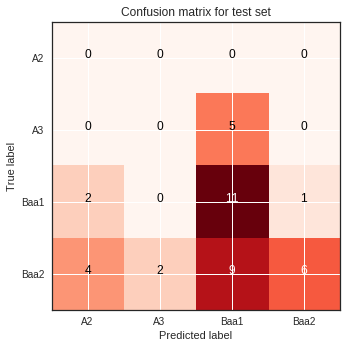

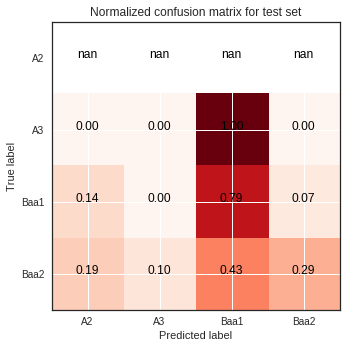

In [17]:
# frequency
rf = RandomForestClassifier(max_depth=40).fit(x_train_tabular, np.reshape(y_train,(len(y_train),)))
print("Pred label on train set:\n", stats.itemfreq(rf.predict(x_train_tabular)))
print("Pred accuracy on train set: ", rf.score(x_train_tabular, y_train))
print("Pred label on test set:\n", stats.itemfreq(rf.predict(x_test_tabular)))
print("Pred accuracy on test set: ", rf.score(x_test_tabular, y_test))

rf_importances = rf.feature_importances_
sort_index = np.argsort(rf_importances)
sort_index = sort_index[::-1]
feature_names = ['Modal_freq','Negative_freq','Positive_freq',
                 'Uncertainty_freq','Litigious_freq','Constraining_freq',
                 'Superfluous_freq','Interesting_freq','Tone_measure']
importances_sorted = [rf_importances[i] for i in sort_index]
features_sorted = [feature_names[i] for i in sort_index]

#plt.figure(figsize=(6,3))
#ax = plt.gca()
#ax.bar(range(9), importances_sorted, color='#B284BE')
#ax.set_xticks(range(9))
#ax.set_xticklabels(features_sorted,rotation=90, fontsize=12, ha="right")
#ax.set_xlim(-.7, 1 * 9)
#ax.set_frame_on(False)

importances_sorted = importances_sorted[::-1]
features_sorted = features_sorted[::-1]


sns.set_style('white',{'axes.grid': False, 'grid.color': '1'})
fig=plt.figure(figsize=(3, 6),facecolor='white')
plt.barh(range(9), importances_sorted, color='#9c2f2f')
plt.yticks(range(9), features_sorted)
plt.grid(None)

plt.savefig('rf_importance.pdf', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')
plt.savefig('rf_importance.png', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

!ls
!mv /content/rf_importance.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/rf_importance.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

train_pred = rf.predict(x_train_tabular)
test_pred = rf.predict(x_test_tabular)

plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(train_pred)), 'train')
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(test_pred)), 'test')


# Compute confusion matrix
train_matrix = confusion_matrix(y_train, train_pred)
test_matrix = confusion_matrix(y_test, test_pred)
np.set_printoptions(precision=2)

train_class_names = ['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3']
test_class_names = [train_class_names[i] for i in np.unique(np.concatenate([np.reshape(y_test,(len(y_test),)),test_pred]))]

# Plot non-normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names,
                      title='Confusion matrix for training set')
plt.savefig('rf_confusion_matrix_train.png', bbox_inches='tight')
plt.savefig('rf_confusion_matrix_train.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names, normalize=True,
                      title='Normalized confusion matrix for training set')

# Plot non-normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names,
                      title='Confusion matrix for test set',
                      datatype='test')
plt.savefig('rf_confusion_matrix_test.png', bbox_inches='tight')
plt.savefig('rf_confusion_matrix_test.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names, normalize=True,
                      title='Normalized confusion matrix for test set',
                      datatype='test')

!ls
!mv /content/rf_confusion_matrix_train.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/rf_confusion_matrix_train.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/rf_confusion_matrix_test.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/rf_confusion_matrix_test.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

In [0]:
# count
rf = RandomForestClassifier(max_depth=40).fit(x_train_tabular, np.reshape(y_train,(len(y_train),)))
print("Pred label on train set:\n", stats.itemfreq(rf.predict(x_train_tabular)))
print("Pred accuracy on train set: ", rf.score(x_train_tabular, y_train))
print("Pred label on test set:\n", stats.itemfreq(rf.predict(x_test_tabular)))
print("Pred accuracy on test set: ", rf.score(x_test_tabular, y_test))

rf_importances = rf.feature_importances_
sort_index = np.argsort(rf_importances)
sort_index = sort_index[::-1]
feature_names = ['Modal','Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting']
importances_sorted = [rf_importances[i] for i in sort_index]
features_sorted = [feature_names[i] for i in sort_index]

plt.figure(figsize=(16,9))
ax = plt.gca()
ax.bar(range(8), importances_sorted, color='#B284BE')
ax.set_xticks(range(8))
ax.set_xticklabels(features_sorted,rotation=90, fontsize=12, ha="right")
ax.set_xlim(-.7, 1 * 8)
ax.set_frame_on(False)

#fig=plt.figure(figsize=(12, 8))
#plt.barh(range(8), importances_sorted)
#plt.yticks(range(8), features_sorted)

plt.savefig('rf_importance_count.pdf', bbox_inches='tight')
plt.savefig('rf_importance_count.png', bbox_inches='tight')

!ls
!mv /content/rf_importance_count.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/rf_importance_count.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

train_pred = rf.predict(x_train_tabular)
test_pred = rf.predict(x_test_tabular)

plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(train_pred)), 'train')
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(test_pred)), 'test')


# Compute confusion matrix
train_matrix = confusion_matrix(y_train, train_pred)
test_matrix = confusion_matrix(y_test, test_pred)
np.set_printoptions(precision=2)

train_class_names = ['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3']
test_class_names = [train_class_names[i] for i in np.unique(np.concatenate([np.reshape(y_test,(len(y_test),)),test_pred]))]

# Plot non-normalized confusion matrix for training set
plt.figure(figsize=(8,8))
plot_confusion_matrix(train_matrix, classes=train_class_names,
                      title='Confusion matrix for training set, without normalization')

# Plot normalized confusion matrix for training set
plt.figure(figsize=(8,8))
plot_confusion_matrix(train_matrix, classes=train_class_names, normalize=True,
                      title='Normalized confusion matrix for training set')

# Plot non-normalized confusion matrix for test set
plt.figure(figsize=(8,8))
plot_confusion_matrix(test_matrix, classes=test_class_names,
                      title='Confusion matrix for test set, without normalization',
                      datatype='test')

# Plot normalized confusion matrix for test set
plt.figure(figsize=(8,8))
plot_confusion_matrix(test_matrix, classes=test_class_names, normalize=True,
                      title='Normalized confusion matrix for test set',
                      datatype='test')


## Bag-of-words Model with Unstructured Data

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy of bag-of-words model with random forest: 0.7094310805651012
Test accuracy of bag-of-words model with random forest: 0.375
bow_importance.pdf  bow_importance.png	gdrive	sample_data
gdrive	sample_data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


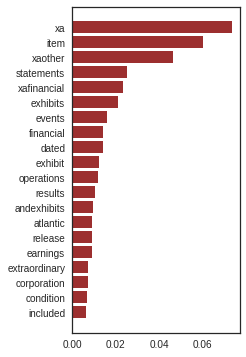

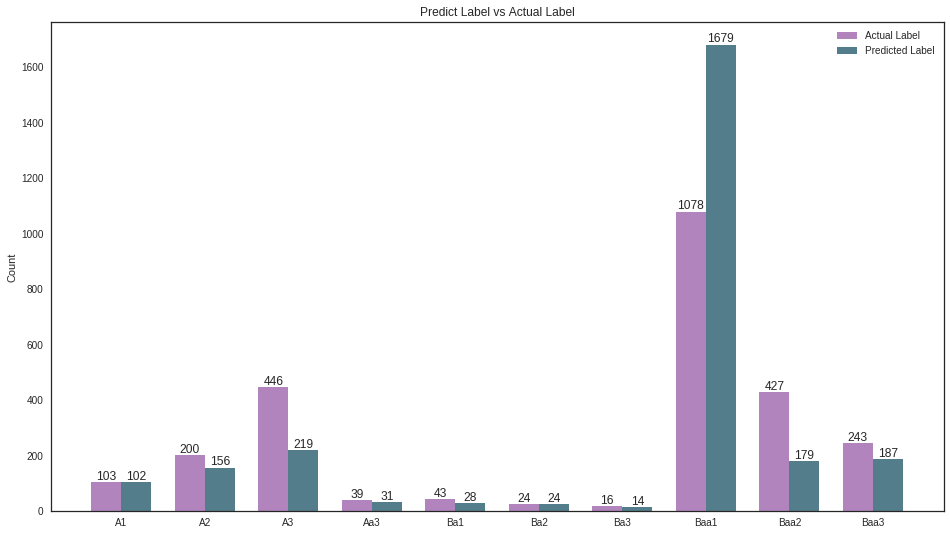

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


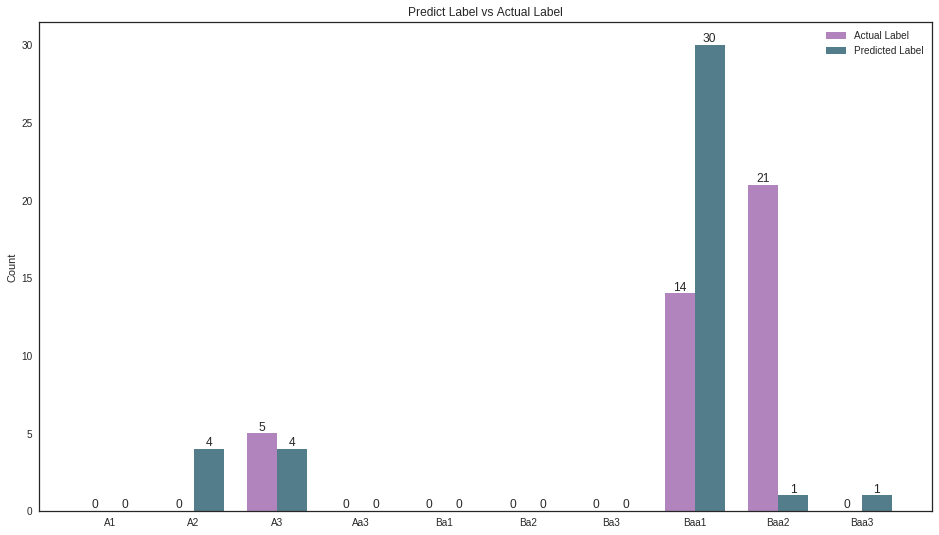

Confusion matrix for training set, without normalization
[[ 102    0    0    0    0    0    0    1    0    0]
 [   0  112    0    0    1    0    0   79    0    8]
 [   0   16  204    0    0    0    0  211    0   15]
 [   0    0    0   31    0    0    0    3    1    4]
 [   0    7    0    0   27    0    0    9    0    0]
 [   0    0    0    0    0   24    0    0    0    0]
 [   0    0    0    0    0    0   14    2    0    0]
 [   0   13   10    0    0    0    0 1039    5   11]
 [   0    4    1    0    0    0    0  244  167   11]
 [   0    4    4    0    0    0    0   91    6  138]]
Normalized confusion matrix for training set
[[0.99 0.   0.   0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.56 0.   0.   0.01 0.   0.   0.4  0.   0.04]
 [0.   0.04 0.46 0.   0.   0.   0.   0.47 0.   0.03]
 [0.   0.   0.   0.79 0.   0.   0.   0.08 0.03 0.1 ]
 [0.   0.16 0.   0.   0.63 0.   0.   0.21 0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.88 0.12 0.   0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix for test set
[[ nan  nan  nan  nan  nan]
 [0.   0.2  0.8  0.   0.  ]
 [0.07 0.   0.93 0.   0.  ]
 [0.14 0.14 0.62 0.05 0.05]
 [ nan  nan  nan  nan  nan]]


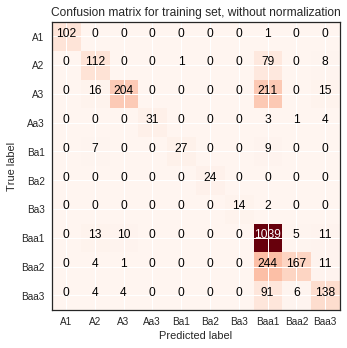

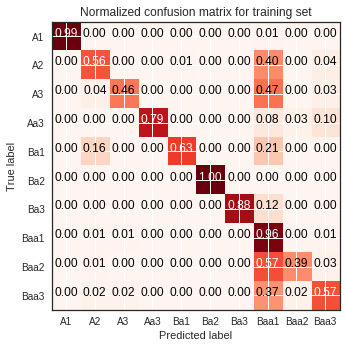

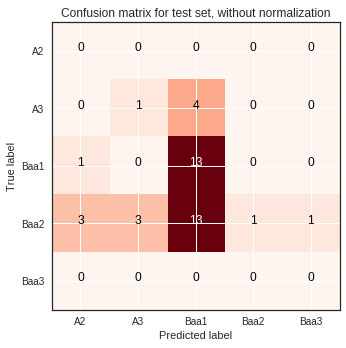

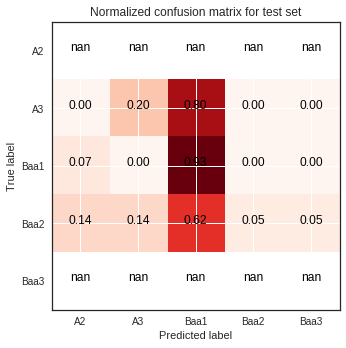

bow_confusion_matrix_test.pdf	fig1_test.pdf	gdrive
bow_confusion_matrix_test.png	fig1_test.png	sample_data
bow_confusion_matrix_train.pdf	fig1_train.pdf
bow_confusion_matrix_train.png	fig1_train.png
fig1_test.pdf  fig1_train.pdf  gdrive
fig1_test.png  fig1_train.png  sample_data


In [6]:
vect = CountVectorizer(stop_words='english',min_df=2)
x_train_vect = vect.fit_transform(x_train_bow)
x_test_vect = vect.transform(x_test_bow)
rf = RandomForestClassifier().fit(x_train_vect,np.reshape(y_train,(len(y_train),)))
rf_features = vect.get_feature_names()

rf_importances = rf.feature_importances_
top = np.argsort(rf_importances)[-20:]
top = top[::-1]

importances_top = [rf_importances[i] for i in top]
features_top = [rf_features[i] for i in top]

print("Training accuracy of bag-of-words model with random forest:",rf.score(x_train_vect,np.reshape(y_train,(len(y_train),))))
print("Test accuracy of bag-of-words model with random forest:",rf.score(x_test_vect,np.reshape(y_test,(len(y_test),))))

#plt.figure(figsize=(16,9))
#ax = plt.gca()
#ax.bar(range(20), importances_top, color='#B284BE')
#ax.set_xticks(range(20))
#ax.set_xticklabels(features_top,rotation=90, fontsize=12, ha="right")
#ax.set_xlim(-.7, 1 * 20)
#ax.set_frame_on(False)

sns.set_style('white',{'axes.grid': False, 'grid.color': '1'})
fig=plt.figure(figsize=(3, 6))
fig.set_facecolor("white")
importances_top = importances_top[::-1]
features_top = features_top[::-1]
plt.barh(range(20), importances_top, color='#9c2f2f')
plt.yticks(range(20), features_top)
plt.grid(None)


plt.savefig('bow_importance.pdf', bbox_inches='tight')
plt.savefig('bow_importance.png', bbox_inches='tight')

!ls
!mv /content/bow_importance.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/bow_importance.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

train_pred = rf.predict(x_train_vect)
test_pred = rf.predict(x_test_vect)

plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(train_pred)), 'train')
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(test_pred)), 'test')

# Compute confusion matrix
train_matrix = confusion_matrix(y_train, train_pred)
test_matrix = confusion_matrix(y_test, test_pred)
np.set_printoptions(precision=2)

train_class_names = ['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3']
test_class_names = [train_class_names[i] for i in np.unique(np.concatenate([np.reshape(y_test,(len(y_test),)),test_pred]))]

# Plot non-normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names,
                      title='Confusion matrix for training set, without normalization')
plt.savefig('bow_confusion_matrix_train.png', bbox_inches='tight')
plt.savefig('bow_confusion_matrix_train.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names, normalize=True,
                      title='Normalized confusion matrix for training set')

# Plot non-normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names,
                      title='Confusion matrix for test set, without normalization',
                      datatype='test')
plt.savefig('bow_confusion_matrix_test.png', bbox_inches='tight')
plt.savefig('bow_confusion_matrix_test.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names, normalize=True,
                      title='Normalized confusion matrix for test set',
                      datatype='test')

plt.show()

!ls
!mv /content/bow_confusion_matrix_train.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/bow_confusion_matrix_train.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/bow_confusion_matrix_test.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/bow_confusion_matrix_test.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

## Neural Network with Unstrctured Data

In [8]:
# meta data
num_words = 1000
max_len = 50
embedding_size = 8
output_cat = 10

model = Sequential()
model.add(Embedding(num_words, embedding_size, input_shape=(max_len,)))
if tensorflow.test.is_gpu_available():
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(CuDNNLSTM(64))
else:
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64))

model.add(Dense(64))
model.add(Dense(output_cat, activation='softmax'))
model.compile(tensorflow.train.AdamOptimizer(learning_rate=0.00001), 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=5,verbose=1)

history = model.fit(x_train_text, y_train, epochs=5, validation_split=0.1, verbose=1, callbacks=[early_stopping])

model.summary()

Epoch 1/5
74/74 [==============================] - 6s 86ms/step - loss: 2.2994 - acc: 0.1236 - val_loss: 2.2997 - val_acc: 0.2252
Epoch 2/5
74/74 [==============================] - 4s 50ms/step - loss: 2.2936 - acc: 0.4328 - val_loss: 2.2961 - val_acc: 0.2252
Epoch 3/5
74/74 [==============================] - 4s 50ms/step - loss: 2.2868 - acc: 0.4328 - val_loss: 2.2916 - val_acc: 0.2252
Epoch 4/5
74/74 [==============================] - 4s 50ms/step - loss: 2.2791 - acc: 0.4328 - val_loss: 2.2860 - val_acc: 0.2252
Epoch 5/5
74/74 [==============================] - 4s 50ms/step - loss: 2.2698 - acc: 0.4328 - val_loss: 2.2790 - val_acc: 0.2252
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 8)             8000      
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 50, 64)            18944     
____________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


Pred label on train set:
 [[   7 2619]]
Pred accuracy on train set:  0.4116074837724322
Pred label on test set:
 [[ 7 40]]
Pred accuracy on test set:  0.35


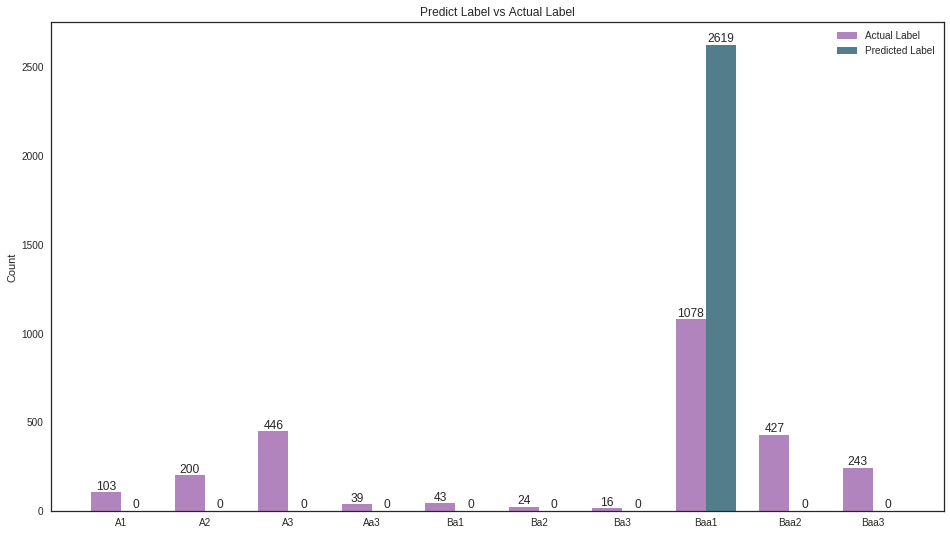

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


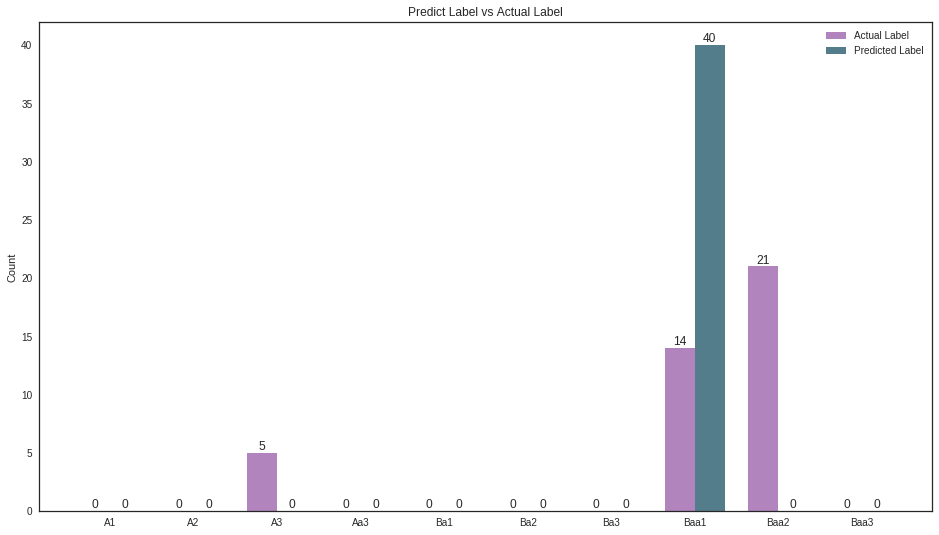

Confusion matrix for training set, without normalization
[[   0    0    0    0    0    0    0  103    0    0]
 [   0    0    0    0    0    0    0  200    0    0]
 [   0    0    0    0    0    0    0  446    0    0]
 [   0    0    0    0    0    0    0   39    0    0]
 [   0    0    0    0    0    0    0   43    0    0]
 [   0    0    0    0    0    0    0   24    0    0]
 [   0    0    0    0    0    0    0   16    0    0]
 [   0    0    0    0    0    0    0 1078    0    0]
 [   0    0    0    0    0    0    0  427    0    0]
 [   0    0    0    0    0    0    0  243    0    0]]
Normalized confusion matrix for training set
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Confusion matrix for test set, witho

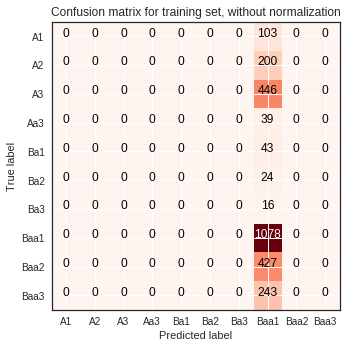

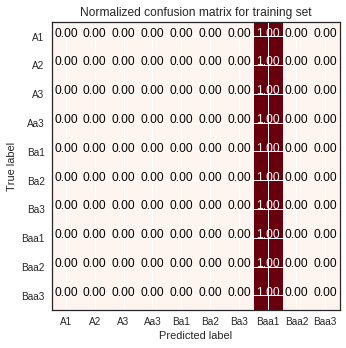

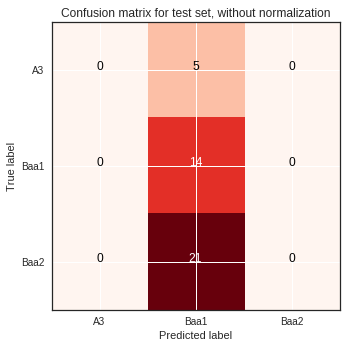

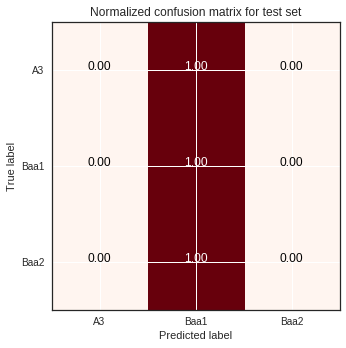

fig1_test.pdf	lstm_confusion_matrix_test.pdf
fig1_test.png	lstm_confusion_matrix_test.png
fig1_train.pdf	lstm_confusion_matrix_train.pdf
fig1_train.png	lstm_confusion_matrix_train.png
gdrive		sample_data
fig1_test.pdf  fig1_train.pdf  gdrive
fig1_test.png  fig1_train.png  sample_data


In [9]:
preds = model.predict(x_train_text)
pred_result_train = []
for i in range(len(x_train_text)):
  pred_result_train.append(np.argmax(preds[i]))
print("Pred label on train set:\n", stats.itemfreq(pred_result_train))
print("Pred accuracy on train set: ", sum(1 for x,y in zip(list(np.reshape(y_train,(len(y_train),))),pred_result_train) if x == y) / float(len(pred_result_train)))

preds = model.predict(x_test_text)
pred_result_test = []
for i in range(len(x_test_text)):
  pred_result_test.append(np.argmax(preds[i]))
print("Pred label on test set:\n", stats.itemfreq(pred_result_test))
print("Pred accuracy on test set: ", sum(1 for x,y in zip(list(np.reshape(y_test,(len(y_test),))),pred_result_test) if x == y) / float(len(pred_result_test)))


plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(pred_result_train)), 'train')
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(pred_result_test)), 'test')


# Compute confusion matrix
train_matrix = confusion_matrix(y_train, pred_result_train)
test_matrix = confusion_matrix(y_test, pred_result_test)
np.set_printoptions(precision=2)

train_class_names = ['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3']
test_class_names = [train_class_names[i] for i in np.unique(np.concatenate([np.reshape(y_test,(len(y_test),)),pred_result_test]))]

# Plot non-normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names,
                      title='Confusion matrix for training set, without normalization')
plt.savefig('lstm_confusion_matrix_train.png', bbox_inches='tight')
plt.savefig('lstm_confusion_matrix_train.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names, normalize=True,
                      title='Normalized confusion matrix for training set')

# Plot non-normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names,
                      title='Confusion matrix for test set, without normalization',
                      datatype='test')
plt.savefig('lstm_confusion_matrix_test.png', bbox_inches='tight')
plt.savefig('lstm_confusion_matrix_test.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names, normalize=True,
                      title='Normalized confusion matrix for test set',
                      datatype='test')

plt.show()

!ls
!mv /content/lstm_confusion_matrix_train.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/lstm_confusion_matrix_train.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/lstm_confusion_matrix_test.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/lstm_confusion_matrix_test.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

## Wide and Deep Model

In [10]:
# meta data
num_words = 1000
max_len = 50
embedding_size = 8
aux_input_cols = 9
output_cat = 10

# unstructured text
main_input = Input(shape=(max_len,), name='main_input')

x = Embedding(output_dim=embedding_size, input_dim=num_words, input_length=max_len)(main_input)

if tensorflow.test.is_gpu_available():
  rnnout = CuDNNGRU(32)(x)
else:
  rnnout = GRU(32, recurrent_activation='relu')(x)

auxiliary_output = Dense(output_cat, activation='softmax', name='aux_output')(rnnout)

# concat with structured tabular data frame
auxiliary_input = Input(shape=(aux_input_cols,), name='aux_input')
x = tensorflow.keras.layers.concatenate([rnnout, auxiliary_input])

#x = Conv1D(32, 7, activation='relu')(x)
#x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.2)(x)

# And finally add the main logistic regression layer
main_output = Dense(output_cat, activation='softmax', name='main_output')(x)



model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

model.compile(optimizer=tensorflow.train.AdamOptimizer(learning_rate=0.00001),
              loss={'main_output': 'sparse_categorical_crossentropy', 'aux_output': 'sparse_categorical_crossentropy'},
              loss_weights={'main_output': 0.5, 'aux_output': 1},
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_aux_output_acc',min_delta=0.001,patience=5,verbose=1)

history = model.fit({'main_input': x_train_text,
                     'aux_input': x_train_tabular},
                    {'main_output': y_train,
                     'aux_output': y_train},
                    validation_split=0.1, epochs=10, batch_size=128, verbose=1, callbacks=[early_stopping])

print(model.summary())

Epoch 1/10
19/19 [==============================] - 1s 56ms/step - loss: 3.4530 - main_output_loss: 2.2997 - aux_output_loss: 2.3032 - main_output_acc: 0.2234 - aux_output_acc: 0.0829 - val_loss: 3.4500 - val_main_output_loss: 2.3003 - val_aux_output_loss: 2.2999 - val_main_output_acc: 0.2252 - val_aux_output_acc: 0.0496
Epoch 2/10
19/19 [==============================] - 1s 52ms/step - loss: 3.4521 - main_output_loss: 2.2991 - aux_output_loss: 2.3026 - main_output_acc: 0.2858 - aux_output_acc: 0.0833 - val_loss: 3.4494 - val_main_output_loss: 2.2999 - val_aux_output_loss: 2.2994 - val_main_output_acc: 0.2328 - val_aux_output_acc: 0.0496
Epoch 3/10
19/19 [==============================] - 1s 50ms/step - loss: 3.4514 - main_output_loss: 2.2987 - aux_output_loss: 2.3020 - main_output_acc: 0.2912 - aux_output_acc: 0.0842 - val_loss: 3.4488 - val_main_output_loss: 2.2996 - val_aux_output_loss: 2.2990 - val_main_output_acc: 0.2366 - val_aux_output_acc: 0.0496
Epoch 4/10
19/19 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


Pred label on train set:
 [[   1    3]
 [   2    9]
 [   4    3]
 [   5    1]
 [   7 2444]
 [   8  154]
 [   9    5]]
Pred accuracy on train set:  0.413516609392898
Pred label on test set:
 [[ 7 40]]
Pred accuracy on test set:  0.35


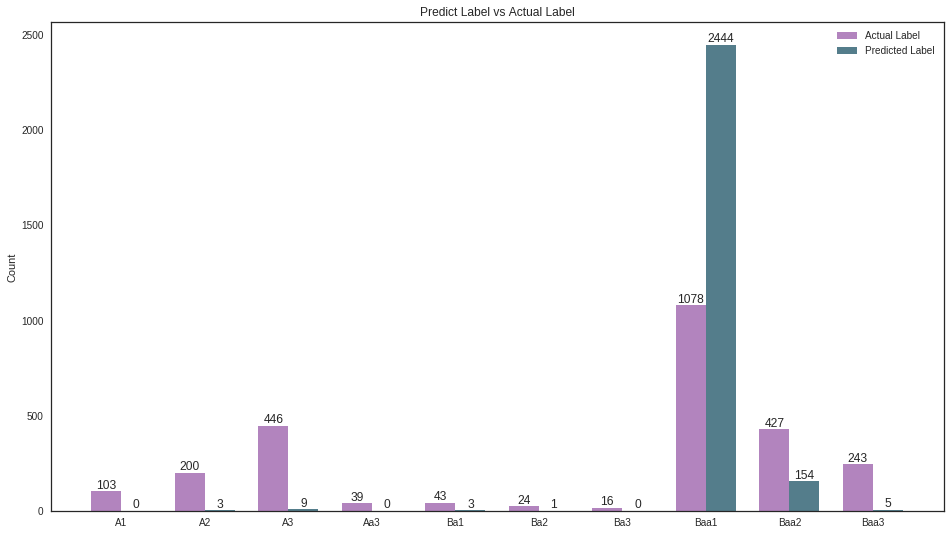

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


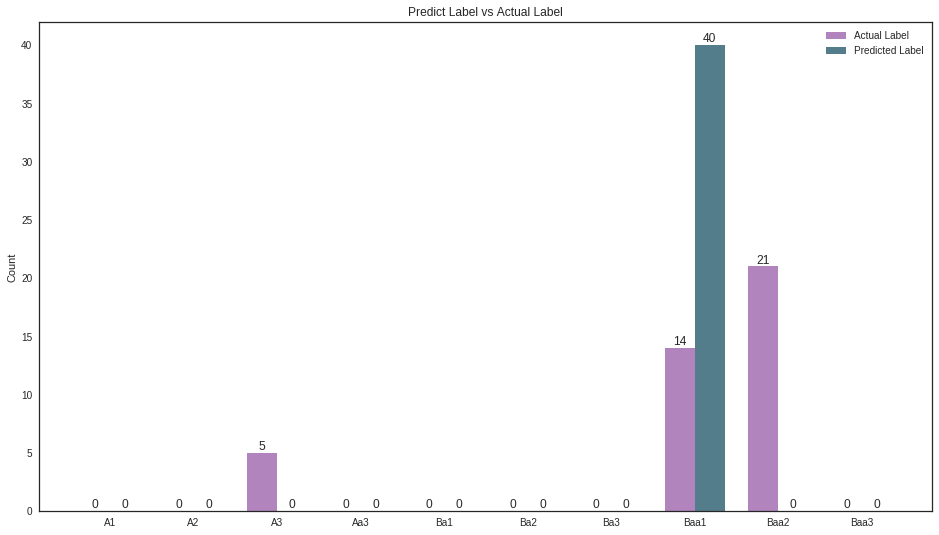

Confusion matrix for training set, without normalization
[[   0    0    2    0    0    0    0   72   28    1]
 [   0    0    0    0    0    0    0  189   11    0]
 [   0    2    1    0    0    0    0  403   39    1]
 [   0    0    0    0    0    0    0   32    7    0]
 [   0    0    0    0    0    0    0   37    6    0]
 [   0    0    0    0    0    0    0   16    8    0]
 [   0    0    0    0    0    0    0    8    8    0]
 [   0    1    4    0    2    0    0 1059   11    1]
 [   0    0    1    0    0    1    0  402   22    1]
 [   0    0    1    0    1    0    0  226   14    1]]
Normalized confusion matrix for training set
[[0.00e+00 0.00e+00 1.94e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.99e-01
  2.72e-01 9.71e-03]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.45e-01
  5.50e-02 0.00e+00]
 [0.00e+00 4.48e-03 2.24e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.04e-01
  8.74e-02 2.24e-03]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.21e-01
  1.79e-

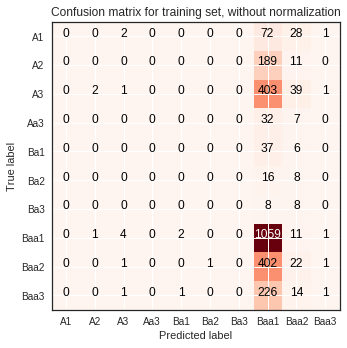

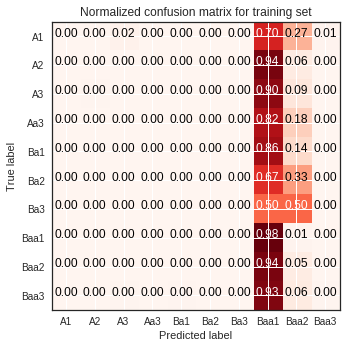

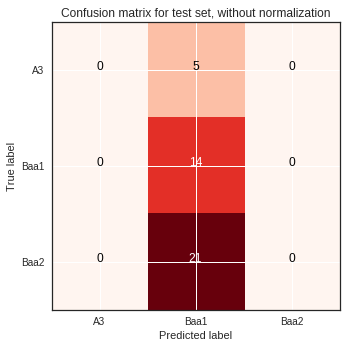

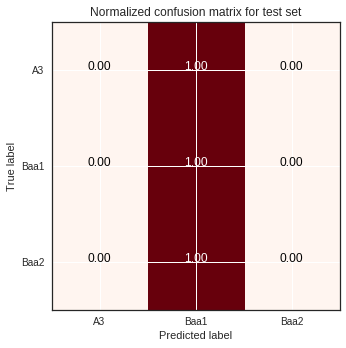

fig1_test.pdf	gdrive			       wnd_confusion_matrix_train.pdf
fig1_test.png	sample_data		       wnd_confusion_matrix_train.png
fig1_train.pdf	wnd_confusion_matrix_test.pdf
fig1_train.png	wnd_confusion_matrix_test.png
fig1_test.pdf  fig1_train.pdf  gdrive
fig1_test.png  fig1_train.png  sample_data


In [11]:
preds = model.predict({'main_input': x_train_text,'aux_input': x_train_tabular})
pred_result_train = []
for i in range(len(x_train_text)):
  pred_result_train.append(np.argmax(preds[0][i]))
print("Pred label on train set:\n", stats.itemfreq(pred_result_train))
print("Pred accuracy on train set: ", sum(1 for x,y in zip(list(np.reshape(y_train,(len(y_train),))),pred_result_train) if x == y) / float(len(pred_result_train)))

preds = model.predict({'main_input': x_test_text,'aux_input': x_test_tabular})
pred_result_test = []
for i in range(len(x_test_text)):
  pred_result_test.append(np.argmax(preds[0][i]))
print("Pred label on test set:\n", stats.itemfreq(pred_result_test))
print("Pred accuracy on test set: ", sum(1 for x,y in zip(list(np.reshape(y_test,(len(y_test),))),pred_result_test) if x == y) / float(len(pred_result_test)))


plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(pred_result_train)), 'train')
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(pred_result_test)), 'test')


# Compute confusion matrix
train_matrix = confusion_matrix(y_train, pred_result_train)
test_matrix = confusion_matrix(y_test, pred_result_test)
np.set_printoptions(precision=2)

train_class_names = ['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3']
test_class_names = [train_class_names[i] for i in np.unique(np.concatenate([np.reshape(y_test,(len(y_test),)),pred_result_test]))]

# Plot non-normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names,
                      title='Confusion matrix for training set, without normalization')
plt.savefig('wnd_confusion_matrix_train.png', bbox_inches='tight')
plt.savefig('wnd_confusion_matrix_train.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_matrix, classes=train_class_names, normalize=True,
                      title='Normalized confusion matrix for training set')

# Plot non-normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names,
                      title='Confusion matrix for test set, without normalization',
                      datatype='test')
plt.savefig('wnd_confusion_matrix_test.png', bbox_inches='tight')
plt.savefig('wnd_confusion_matrix_test.pdf', bbox_inches='tight')

# Plot normalized confusion matrix for test set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_matrix, classes=test_class_names, normalize=True,
                      title='Normalized confusion matrix for test set',
                      datatype='test')

plt.show()

!ls
!mv /content/wnd_confusion_matrix_train.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/wnd_confusion_matrix_train.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/wnd_confusion_matrix_test.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/wnd_confusion_matrix_test.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

## Word Cloud

In [0]:
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/fox.csv',usecols=['only_eng_words'])
comcast = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/comcast.csv',usecols=['only_eng_words'])
att = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/att.csv',usecols=['only_eng_words'])
verizon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/verizon.csv',usecols=['only_eng_words'])
cbs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/cbs.csv',usecols=['only_eng_words'])
only_eng_words = pd.concat([fox,comcast,att,verizon,cbs],ignore_index=True)

In [0]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

mywc = word_count(all_str)
import operator
sorted_mywc = sorted(mywc.items(), key=operator.itemgetter(1),reverse=True)

In [4]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
mystopwords = list(set(stopwords.words('english')))
mystopwords += ['font','style','bottom','width','border','size','text','m',
                'align','p','padding','family','top','color','left','times',
               'new','right','margin','w','b','normal','solid','a','o','min',
               'l','s','t','n','div','x','r','v','z','g','c','class','weight',
               'none','f','false','i','indent','e','vertical','u','by','h','variant',
               'transform','q','any','d','other','name','be','inherit','us','is',
               'type','k','y','this','from','j','by','for','and','or','of','with',
                'that','such','white','space','at','center','period','paragraph',
               'publisher','are','not','which','bold','reference','an','our','date',
               'no','under','its','may','will','have','if','was','ye','sup','per',
                'na','one','it','been','were','double','section','hidden','topic',
               'black','display','true','transparent','role','subparagraph',
                'definition','help','ending','prefix','overflow','clear','height',
               'link','collapse','line','time']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
all_str = ''.join(only_eng_words['only_eng_words']).upper()
for word in mystopwords:
  all_str = all_str.replace(word, '')

In [6]:
!pip install wordcloud
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white",width=820,height=200,max_font_size=40,stopwords=mystopwords).generate(all_str)

    100% |████████████████████████████████| 368kB 23.5MB/s 


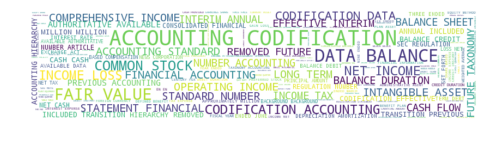

gdrive	sample_data  word_cloud.png
mv: cannot stat '/content/word_cloud.pdf': No such file or directory
gdrive	sample_data


In [7]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imsave("word_cloud.png", wordcloud, format='png', dpi=10000)
#plt.imsave("word_cloud.pdf", wordcloud, format='pdf')
#plt.savefig('word_cloud.pdf', bbox_inches='tight')
#plt.savefig('word_cloud.png', bbox_inches='tight')

!ls
!mv /content/word_cloud.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/word_cloud.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

## EDA

In [0]:
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment.csv')
moodys, sentiment, company = load_data('fox')

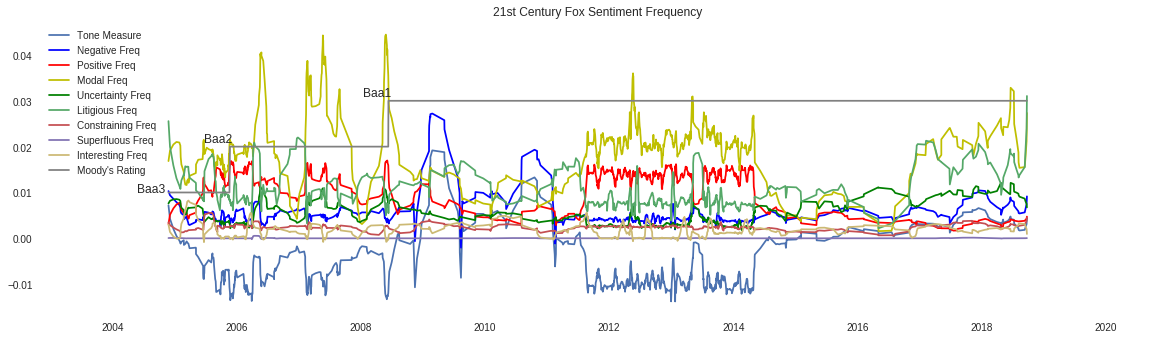

fig1_test.pdf  fig1_train.pdf  fox_sentiment.pdf  gdrive
fig1_test.png  fig1_train.png  fox_sentiment.png  sample_data
fig1_test.pdf  fig1_train.pdf  gdrive
fig1_test.png  fig1_train.png  sample_data


In [125]:
import scipy
from scipy import signal

def myplot(df):
  date = pd.to_datetime(df['findexdate'])

  plt.figure(figsize=(20,27/5.0),facecolor='white')
  plt.margins(x=.15)
  plt.plot(date, signal.savgol_filter(df['Negative_score'],19,3), label='Tone Measure')
  plt.plot(date, signal.savgol_filter(df['Negative_freq'],19,3), label='Negative Freq')
  plt.plot(date, signal.savgol_filter(df['Positive_freq'],19,3), label='Positive Freq')
  plt.plot(date, signal.savgol_filter(df['Modal_freq'],19,3), label='Modal Freq')
  plt.plot(date, signal.savgol_filter(df['Uncertainty_freq'],19,3), label='Uncertainty Freq')
  plt.plot(date, signal.savgol_filter(df['Litigious_freq'],19,3), label='Litigious Freq')
  plt.plot(date, signal.savgol_filter(df['Constraining_freq'],19,3), label='Constraining Freq')
  plt.plot(date, signal.savgol_filter(df['Superfluous_freq'],19,3), label='Superfluous Freq')
  plt.plot(date, signal.savgol_filter(df['Interesting_freq'],19,3), label='Interesting Freq')
  plt.plot(date, [0.01]*74+[0.02]*205+[0.03]*769, color='gray', label='Moody\'s Rating')
  plt.text('2004-05-25', 0.01, 'Baa3', fontsize=12)
  plt.text('2005-06-21', 0.021, 'Baa2', fontsize=12)
  plt.text('2008-01-11', 0.031, 'Baa1', fontsize=12)
  plt.title('21st Century Fox Sentiment Frequency')
  plt.legend(loc='upper left')
  plt.rcParams['axes.facecolor'] = 'white'

  plt.savefig('fox_sentiment.png', bbox_inches='tight')
  plt.savefig('fox_sentiment.pdf', bbox_inches='tight')



  plt.show()
  
myplot(fox)


!ls
!mv /content/fox_sentiment.png /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!mv /content/fox_sentiment.pdf /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/model_plots
!ls

## Plotly Frequency

In [0]:
# sentiment frequency
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#import scipy
#from scipy import signal
#signal.savgol_filter

plotly.tools.set_credentials_file(username='yunwencai', api_key='9R0DAo2gnrurCju4VJQM')

def interactive_plot(moodys,df,company):

  # All
  negative_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Interesting_freq'],
      name = "Interesting Frequency"
  ) 
  negative_score = go.Scatter(
      x = df['findexdate'],
      y = df['Negative_score'],
      name = "Negative Score"
  ) 
  
  # 10-K
  negative_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 8-K
  negative_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 10-Q
  negative_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Negative_score'],
      name = "Negative Score"
  )
  
  moodys_text = go.Scatter(
    x=moodys['Effective Date'],
    #y=[df.drop(['Unnamed: 0'],axis=1)._get_numeric_data().max(axis=0).max()]*moodys.shape[0],
    y=[0]*moodys.shape[0],
    mode='markers+text',
    name='Moody\'s Rating',
    text=moodys['Moody\'s Rating'],
    textposition='bottom center',
    textfont=dict(
        family='sans serif',
        size=12,
        color='#ff7f0e'
    )
  )
  
  layout = dict(
    title=company+' Sentiment Frequency',
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='backward'),
                dict(count=5,
                     label='5y',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10y',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis=dict(title='Frequency')
  )
  
  updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'All Filings',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' All Filings'}]),
            dict(label = '10-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 10-Ks'}]),
            dict(label = '8-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 8-Ks'}]),
            dict(label = '10-Qs',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      True]},
                         {'title': company+' 10-Qs'}])
        ]),
      )
  ])
  
  layout['updatemenus'] = updatemenus

  data = [negative_freq, positive_freq, modal_freq, uncertainty_freq,
         litigious_freq, constraining_freq, superfluous_freq, interesting_freq,negative_score,
         negative_freq_10k, positive_freq_10k, modal_freq_10k, uncertainty_freq_10k,
         litigious_freq_10k, constraining_freq_10k, superfluous_freq_10k, interesting_freq_10k,negative_score_10k,
         negative_freq_8k, positive_freq_8k, modal_freq_8k, uncertainty_freq_8k,
         litigious_freq_8k, constraining_freq_8k, superfluous_freq_8k, interesting_freq_8k,negative_score_8k,
         negative_freq_10q, positive_freq_10q, modal_freq_10q, uncertainty_freq_10q,
         litigious_freq_10q, constraining_freq_10q, superfluous_freq_10q, interesting_freq_10q,negative_score_10q,
         moodys_text]  
  fig = dict(data=data, layout=layout)

  #plotly.offline.plot(fig, filename='fox_sentiment_analysis.html', auto_open=False)
  return py.iplot(fig, filename=company+' Sentiment Frequency')

interactive_plot(moodys,sentiment,company)

##Plotly Frequency with Smoothing

In [0]:
# sentiment frequency
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import scipy
from scipy import signal
#signal.savgol_filter

plotly.tools.set_credentials_file(username='yunwencai', api_key='9R0DAo2gnrurCju4VJQM')

def interactive_plot(moodys,df,company):

  # All
  negative_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  ) 
  negative_score = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Negative_score'],19,3),
      name = "Negative Score"
  ) 
  
  # 10-K
  negative_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 8-K
  negative_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  )
  negative_score_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Negative_score'],19,3),
      name = "Negative Score"
  )
  
  # 10-Q
  negative_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  )
  negative_score_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Negative_score'],19,3),
      name = "Negative Score"
  )
  
  moodys_text = go.Scatter(
    x=moodys['Effective Date'],
    #y=[df.drop(['Unnamed: 0'],axis=1)._get_numeric_data().max(axis=0).max()]*moodys.shape[0],
    y=[0]*moodys.shape[0],
    mode='markers+text',
    name='Moody\'s Rating',
    text=moodys['Moody\'s Rating'],
    textposition='bottom center',
    textfont=dict(
        family='sans serif',
        size=12,
        color='#ff7f0e'
    )
  )
  
  layout = dict(
    title=company+' Sentiment Frequency',
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='backward'),
                dict(count=5,
                     label='5y',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10y',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis=dict(title='Frequency')
  )
  
  updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'All Filings',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' All Filings'}]),
            dict(label = '10-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 10-Ks'}]),
            dict(label = '8-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 8-Ks'}]),
            dict(label = '10-Qs',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      True]},
                         {'title': company+' 10-Qs'}])
        ]),
      )
  ])
  
  layout['updatemenus'] = updatemenus

  data = [negative_freq, positive_freq, modal_freq, uncertainty_freq,
         litigious_freq, constraining_freq, superfluous_freq, interesting_freq,negative_score,
         negative_freq_10k, positive_freq_10k, modal_freq_10k, uncertainty_freq_10k,
         litigious_freq_10k, constraining_freq_10k, superfluous_freq_10k, interesting_freq_10k,negative_score_10k,
         negative_freq_8k, positive_freq_8k, modal_freq_8k, uncertainty_freq_8k,
         litigious_freq_8k, constraining_freq_8k, superfluous_freq_8k, interesting_freq_8k,negative_score_8k,
         negative_freq_10q, positive_freq_10q, modal_freq_10q, uncertainty_freq_10q,
         litigious_freq_10q, constraining_freq_10q, superfluous_freq_10q, interesting_freq_10q,negative_score_10q,
         moodys_text]  
  fig = dict(data=data, layout=layout)

  #plotly.offline.plot(fig, filename='cbs_sentiment_analysis.html', auto_open=False)
  return py.iplot(fig, filename=company+' Sentiment Frequency')

interactive_plot(moodys,sentiment,company)

In [0]:
#!ls
#!mv /content/cbs_sentiment_analysis.html /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/sentiment_frequency_plot_w_smoothing

cbs_sentiment_analysis.html  gdrive  sample_data
